# Detecção de Fraudes com Rede Neural (Colab)

Este notebook executa o pipeline completo solicitado:
1) Baixar os dados do Google Drive (via `gdown`)
2) Treinar um **modelo base** de MLP (Keras/TensorFlow)
3) Calcular **métricas**: *accuracy (precisão global)*, **precision**, **recall**, **F1-score**, **AUC-ROC**, **matriz de confusão**
4) Fazer **ajuste fino** de hiperparâmetros com **RandomizedSearchCV** e **GridSearchCV** (scikit-learn + scikeras)
5) **Comparar** os resultados do modelo base vs. o modelo otimizado
6) Documentar observações e salvar saídas


In [1]:
!pip -q install scikeras imbalanced-learn

!pip install --upgrade scikit-learn==1.5.1 scikeras==0.12.0

%pip install gdown
import gdown

import sys, numpy as np, pandas as pd, matplotlib.pyplot as plt

print("Python:", sys.version)
print("Pacotes OK.")

ERROR: Ignored the following versions that require a different python version: 0.10.0 Requires-Python >=3.7.0,<3.11.0; 0.11.0 Requires-Python >=3.8.0,<3.12.0; 0.12.0 Requires-Python >=3.8.0,<3.12.0; 0.2.0 Requires-Python >=3.6.7,<3.9; 0.2.1 Requires-Python >=3.6.7,<3.9; 0.6.0 Requires-Python >=3.7.0,<3.10.0; 0.6.1 Requires-Python >=3.7.0,<3.10.0; 0.7.0 Requires-Python >=3.7.0,<3.10.0; 0.8.0 Requires-Python >=3.7.0,<3.11.0; 0.9.0 Requires-Python >=3.7.0,<3.11.0
ERROR: Could not find a version that satisfies the requirement scikeras==0.12.0 (from versions: 0.1.6, 0.1.7, 0.1.8, 0.3.0, 0.3.1, 0.3.3, 0.4.0, 0.4.1, 0.13.0)
ERROR: No matching distribution found for scikeras==0.12.0
Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
Pacotes OK.


In [2]:
# --- Auto-fix de versões (execute esta célula antes de tudo) ---
# Este bloco corrige automaticamente a combinação de versões e reinicia o runtime.
import os, sys, subprocess, importlib
from packaging.version import Version

def _ver(modname):
    try:
        return importlib.import_module(modname).__version__
    except Exception:
        return "N/A"

def ensure_compatible_versions():
    try:
        import sklearn, scikeras
        skl_v = _ver("sklearn")
        sck_v = _ver("scikeras")
        need_fix = (Version(skl_v) >= Version("1.6")) or (Version(sck_v) > Version("0.12.0"))
        print(f"Status atual: scikit-learn={skl_v}, scikeras={sck_v}")
        if need_fix:
            print("Aplicando correção: scikit-learn==1.5.1, scikeras==0.12.0 ...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-q",
                                   "scikit-learn==1.5.1", "scikeras==0.12.0"])
            # Limpa a saída e reinicia o processo do kernel para carregar versões novas
            from IPython.display import clear_output
            clear_output()
            print("Reiniciando runtime para aplicar versões...")
            os.kill(os.getpid(), 9)
        else:
            print("Versões já compatíveis. Pode seguir.")
    except Exception as e:
        print("Falha ao verificar/aplicar correção de versões:", e)

ensure_compatible_versions()


Status atual: scikit-learn=1.6.1, scikeras=0.13.0
Aplicando correção: scikit-learn==1.5.1, scikeras==0.12.0 ...
Falha ao verificar/aplicar correção de versões: Command '['/usr/bin/python3', '-m', 'pip', 'install', '-q', 'scikit-learn==1.5.1', 'scikeras==0.12.0']' returned non-zero exit status 1.


## 2) Download e carregamento dos dados

In [3]:
import os

arquivo_destino_colab = "dataset.csv"
doc_id = "1u_OWAPkIdgJw1ah5xP_dGBFMSANxjxEl"
URL = f"https://drive.google.com/uc?id={doc_id}"
gdown.download(URL, arquivo_destino_colab, quiet=False)

assert os.path.exists(arquivo_destino_colab), "Arquivo não baixado. Verifique o DOC_ID e permissões do Drive."
df = pd.read_csv(arquivo_destino_colab)

print(df.shape)
df.head().head()

Downloading...
From (original): https://drive.google.com/uc?id=1u_OWAPkIdgJw1ah5xP_dGBFMSANxjxEl
From (redirected): https://drive.google.com/uc?id=1u_OWAPkIdgJw1ah5xP_dGBFMSANxjxEl&confirm=t&uuid=8d54a25b-af93-435f-8fdb-989011ebb157
To: /content/dataset.csv
100%|██████████| 151M/151M [00:02<00:00, 71.6MB/s]


(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## 3) Inspeção e preparação dos dados

Essa parte prepara os dados para o modelo, garantindo: identificação da estrutura e do desbalanceamento da base, separação correta entre variáveis preditoras e alvo, divisão estratificada em treino e teste, e padronização dos atributos numéricos. Tudo isso é essencial para um treinamento consistente e resultados mais confiáveis.

In [4]:
print("Colunas:", list(df.columns))
print("\nContagem de classes (esperado desbalanceamento):")
print(df['Class'].value_counts(dropna=False))

TARGET_COL = 'Class'
y = df[TARGET_COL].astype(int)

# Seleção de atributos: usa todas as colunas numéricas exceto o alvo
X = df.select_dtypes(include='number').drop(columns=[TARGET_COL], errors='ignore')

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Tamanhos: ", X_train.shape, X_test.shape)

Colunas: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']

Contagem de classes (esperado desbalanceamento):
Class
0    284315
1       492
Name: count, dtype: int64
Tamanhos:  (227845, 30) (56962, 30)


Os resultados mostram que:

- O dataset contém 30 variáveis preditoras mais a coluna Class, que é a variável alvo indicando fraude (1) ou não (0).

- Há um forte desbalanceamento: apenas 492 transações fraudulentas contra 284.315 não fraudulentas, ou seja, menos de 0,2% do total. Esse desbalanceamento exige técnicas adequadas, como métricas focadas em classes minoritárias (AUC, recall) ou balanceamento dos dados.

- Após a divisão treino-teste, temos 227.845 amostras para treino e 56.962 para teste, preservando o mesmo número de variáveis (30) e mantendo a proporção de classes através da estratificação.

## 4) Modelo base (MLP)

Esse código constrói e treina um modelo baseline de rede neural para detecção de fraudes. Ele usa uma rede simples com camadas densas, dropout para regularização e otimização com Adam. O treino inclui validação e early stopping para evitar overfitting. Por fim, exibe a melhor AUC, servindo como ponto de partida para comparar modelos mais avançados.

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def build_baseline(input_dim):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(16, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  loss='binary_crossentropy',
                  metrics=[keras.metrics.AUC(name='auc')])
    return model

baseline = build_baseline(X_train_scaled.shape[1])
es = keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=5, restore_best_weights=True)
hist = baseline.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=50, batch_size=2048, callbacks=[es], verbose=0
)

print("Melhor AUC (val):", max(hist.history['val_auc']))

Melhor AUC (val): 0.9512783885002136


Uma AUC de ~0,95 no conjunto de validação indica que o modelo baseline já está conseguindo distinguir muito bem as transações fraudulentas das não fraudulentas.

- Ponto positivo: mesmo sem tuning avançado, a rede neural apresenta uma ótima capacidade de classificação.

- Atenção: esse valor ainda precisa ser validado no conjunto de teste para confirmar se não há overfitting.

### Métricas do modelo base

Esse trecho avalia o modelo baseline no conjunto de teste:

- Gera probabilidades (predict) e classes (>=0.5).

- Calcula métricas principais: acurácia, precisão, recall, F1 e AUC, oferecendo uma visão completa do desempenho.

- Exibe a matriz de confusão, mostrando acertos e erros nas classes majoritária (não fraude) e minoritária (fraude).

- Plota a curva ROC com a AUC, útil para analisar a capacidade de separação do modelo entre classes em diferentes limiares de decisão.

É um resumo do desempenho geral, com foco na robustez do modelo para um problema desbalanceado.

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
accuracy     0.999350
precision    0.801980
recall       0.826531
f1           0.814070
auc          0.978148
dtype: float64

Matriz de confusão (base):
 [[56844    20]
 [   17    81]]


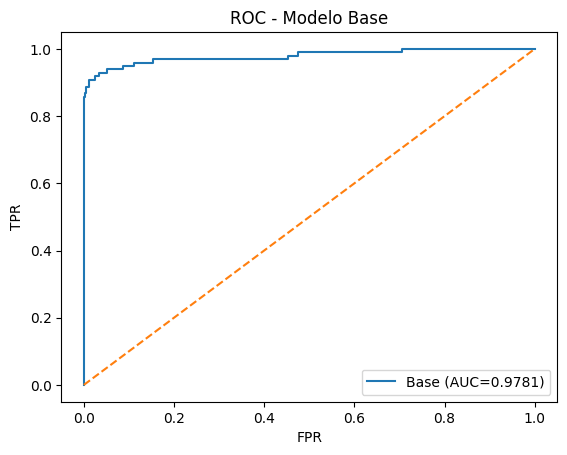

In [6]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Probabilidades e predições
y_prob_base = baseline.predict(X_test_scaled).ravel()
y_pred_base = (y_prob_base >= 0.5).astype(int)

metrics_base = {
    "accuracy": accuracy_score(y_test, y_pred_base),
    "precision": precision_score(y_test, y_pred_base, zero_division=0),
    "recall": recall_score(y_test, y_pred_base, zero_division=0),
    "f1": f1_score(y_test, y_pred_base, zero_division=0),
    "auc": roc_auc_score(y_test, y_prob_base),
}
print(pd.Series(metrics_base))

cm_base = confusion_matrix(y_test, y_pred_base)
print("\nMatriz de confusão (base):\n", cm_base)

# Curva ROC
fpr_b, tpr_b, _ = roc_curve(y_test, y_prob_base)
plt.figure()
plt.plot(fpr_b, tpr_b, label=f"Base (AUC={metrics_base['auc']:.4f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC - Modelo Base")
plt.legend()
plt.show()

O modelo baseline teve excelente desempenho:

- AUC = 0.978 mostra ótima separação entre fraudes e não fraudes.

- Alta precisão (0.80) e bom recall (0.83), com equilíbrio no F1 (0.81).

- Poucos erros na matriz de confusão, com poucas fraudes não detectadas.

Ainda é possível otimizar o recall ou ajustar o threshold para reduzir falsos negativ

## 5) Ajuste de hiperparâmetros (RandomizedSearchCV ➜ GridSearchCV)

Essa parte do código realiza o tuning do modelo Keras de forma rápida e eficiente. Primeiro, os dados são preparados para garantir consistência e reprodutibilidade. Em seguida, é criada uma rede neural com hiperparâmetros ajustáveis, como número de camadas, unidades, taxa de dropout e taxa de aprendizado. O desempenho de cada configuração é avaliado por validação cruzada estratificada, utilizando a métrica AUC como referência. Depois, é feita uma busca aleatória para explorar várias combinações e, em seguida, um grid search fino para refinar os melhores parâmetros encontrados. Por fim, o modelo é treinado com esses parâmetros otimizados para obter o melhor desempenho possível.

In [7]:
# ============================================
# Hyperparam tuning Keras PURO (compatível c/ scikit-learn 1.6+)
# - Randomized Search (rápido)
# - Grid fino em torno do melhor (compacto)
# - CV estratificado + métrica ROC AUC
# - Sem SciKeras (evita __sklearn_tags__)
# ============================================

import numpy as np
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score
import tensorflow as tf

# ---------- (Opcional) threads mais previsíveis em CPU ----------
try:
    tf.config.threading.set_intra_op_parallelism_threads(1)
    tf.config.threading.set_inter_op_parallelism_threads(1)
    import os
    os.environ["OMP_NUM_THREADS"] = "1"
except Exception:
    pass

# ---------- Reprodutibilidade ----------
np.random.seed(42)
tf.random.set_seed(42)

# ---------- util: garantir arrays NumPy mesmo que X/y sejam pandas ----------
def to_np(a):
    if hasattr(a, "to_numpy"):
        return a.to_numpy()
    if hasattr(a, "values"):
        return a.values
    return np.asarray(a)

X_np = to_np(X_train_scaled)
y_np = to_np(y_train).ravel().astype(int)

# ---------- Modelo ----------
def make_model(n_hidden=2, units=64, dropout=0.2, lr=1e-3, input_dim=None):
    if input_dim is None:
        input_dim = X_np.shape[1]
    model = keras.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    for _ in range(int(n_hidden)):
        model.add(layers.Dense(int(units), activation="relu"))
        model.add(layers.Dropout(float(dropout)))
    model.add(layers.Dense(1, activation="sigmoid"))
    opt = keras.optimizers.Adam(learning_rate=float(lr))
    # nome da métrica "auc" para monitorar "val_auc"
    model.compile(optimizer=opt, loss="binary_crossentropy",
                  metrics=[keras.metrics.AUC(name="auc")])
    return model

# ---------- Avaliação por CV ----------
def cv_auc_score(params, X, y, n_splits=3, random_state=42, verbose=0):
    """Treina/avalia por K-fold estratificado e retorna AUC médio de validação."""
    p = dict(params)
    p.setdefault("n_hidden", 2)
    p.setdefault("units", 64)
    p.setdefault("dropout", 0.2)
    p.setdefault("lr", 1e-3)
    p.setdefault("batch_size", 2048)
    p.setdefault("epochs", 40)
    p.setdefault("patience", 4)

    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    aucs = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y), start=1):
        tf.keras.backend.clear_session()
        model = make_model(n_hidden=p["n_hidden"], units=p["units"], dropout=p["dropout"],
                           lr=p["lr"], input_dim=X.shape[1])

        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor="val_auc", mode="max",
                patience=int(p["patience"]), restore_best_weights=True
            )
        ]

        model.fit(
            X[train_idx], y[train_idx],
            validation_data=(X[val_idx], y[val_idx]),
            epochs=int(p["epochs"]),
            batch_size=int(p["batch_size"]),
            verbose=0,
            callbacks=callbacks
        )

        y_proba = model.predict(X[val_idx], verbose=0).ravel()
        auc = roc_auc_score(y[val_idx], y_proba)
        aucs.append(auc)

        if verbose:
            print(f"  Fold {fold}/{n_splits}: AUC={auc:.5f}")

    return float(np.mean(aucs))

# ---------- Amostradores ESCALARES (sem DeprecationWarning) ----------
def sample_loguniform(low, high, rng):
    return float(np.exp(rng.uniform(np.log(low), np.log(high))))

def sample_randint(low, high, rng):
    # high exclusivo, retorna escalar
    return int(rng.randint(low, high))

# ---------- Randomized Search ----------
def randomized_search_keras(
    X, y,
    n_iter=5,              # FAST MODE: antes 15
    cv_splits=2,           # FAST MODE: antes 3
    random_state=42,
    n_hidden_space=(1, 4),         # randint [1,4)
    units_space=(16, 256),         # randint [16,256)
    dropout_choices=(0.0, 0.1, 0.2, 0.3, 0.4),
    lr_log_space=(1e-4, 3e-2),     # log-uniform
    batch_choices=(2048, 4096),    # FAST MODE: batches maiores = menos steps/epoch
    epoch_choices=(15, 25),        # FAST MODE: antes (30, 40, 60)
    patience=2                     # FAST MODE: early stopping mais agressivo
):
    rng = np.random.RandomState(random_state)
    results = []
    best = {"score": -np.inf, "params": None}

    for i in range(n_iter):
        params = {
            "n_hidden": sample_randint(n_hidden_space[0], n_hidden_space[1], rng),
            "units": sample_randint(units_space[0], units_space[1], rng),
            "dropout": float(rng.choice(dropout_choices)),
            "lr": sample_loguniform(lr_log_space[0], lr_log_space[1], rng),
            "batch_size": int(rng.choice(batch_choices)),
            "epochs": int(rng.choice(epoch_choices)),
            "patience": int(patience),
        }
        score = cv_auc_score(params, X, y, n_splits=cv_splits, random_state=random_state)
        results.append((params, score))
        if score > best["score"]:
            best = {"score": score, "params": params}
        print(f"[Randomized {i+1}/{n_iter}] AUC={score:.5f} | {params}")

    return best, results

# ---------- Grid fino (compacto) ----------
def local_grid_search_keras(
    X, y, best_params, cv_splits=2, random_state=42, fast=True
):
    bp = dict(best_params)

    if fast:
        # Vizinhança compacta (muito mais rápido)
        n_hidden_list = [bp["n_hidden"]]
        units_list    = [bp["units"]]
        drop          = float(bp["dropout"])
        dropout_list  = [round(drop, 2)]
        lr_list       = [bp["lr"], bp["lr"]/2.0]  # 2 pontos
        batch_list    = [max(2048, int(bp.get("batch_size", 2048)))]
        epoch_list    = [min(25, int(bp.get("epochs", 25)))]
    else:
        # Vizinhança mais ampla (mais lenta)
        n_hidden_list = sorted(set([max(1, bp["n_hidden"]-1), bp["n_hidden"], bp["n_hidden"]+1]))
        units_list    = sorted(set([max(16, bp["units"]//2), bp["units"], min(512, bp["units"]*2)]))
        drop          = float(bp["dropout"])
        dropout_list  = sorted(set([max(0.0, round(drop-0.1, 2)), round(drop, 2), min(0.5, round(drop+0.1, 2))]))
        lr_list       = [bp["lr"]/2.0, bp["lr"], bp["lr"]*2.0]
        batch_list    = [1024, 2048]
        epoch_list    = [40, 60]

    grid_results = []
    best = {"score": -np.inf, "params": None}

    for nh in n_hidden_list:
        for un in units_list:
            for dr in dropout_list:
                for lr in lr_list:
                    for bs in batch_list:
                        for ep in epoch_list:
                            params = {
                                "n_hidden": int(nh),
                                "units": int(un),
                                "dropout": float(dr),
                                "lr": float(lr),
                                "batch_size": int(bs),
                                "epochs": int(ep),
                                "patience": 2,  # agressivo no grid
                            }
                            score = cv_auc_score(params, X, y, n_splits=cv_splits, random_state=random_state)
                            grid_results.append((params, score))
                            if score > best["score"]:
                                best = {"score": score, "params": params}
                            print(f"[Grid] AUC={score:.5f} | {params}")

    return best, grid_results

# =============== EXECUÇÃO (FAST MODE) ===============
# Dica: se quiser ainda mais velocidade, descomente o bloco de subamostragem abaixo.
"""
# --- Subamostragem estratificada para protótipo rápido (mantém 30% da base) ---
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.70, random_state=42)
for small_idx, _ in sss.split(X_np, y_np):
    X_run = X_np[small_idx]
    y_run = y_np[small_idx]
"""
# Sem subamostra: rode na base toda
X_run, y_run = X_np, y_np

# 1) Randomized
best_random, random_results = randomized_search_keras(
    X_run, y_run,
    n_iter=5, cv_splits=2, random_state=42,
    epoch_choices=(15, 25), batch_choices=(2048, 4096), patience=2
)
print("\nMelhores parâmetros (Randomized):", best_random["params"])
print("Melhor AUC (cv) Randomized:", best_random["score"])

# 2) Grid fino (compacto)
best_grid, grid_results = local_grid_search_keras(
    X_run, y_run, best_params=best_random["params"], cv_splits=2, random_state=42, fast=True
)
print("\nMelhores parâmetros (Grid):", best_grid["params"])
print("Melhor AUC (cv) Grid:", best_grid["score"])

# 3) Treino final no conjunto COMPLETO com os melhores hiperparâmetros
tf.keras.backend.clear_session()
tuned = make_model(**{k: best_grid["params"][k] for k in ["n_hidden", "units", "dropout", "lr"]})
hist = tuned.fit(
    X_np, y_np,
    validation_split=0.2,
    epochs=int(min(25, best_grid["params"]["epochs"])),
    batch_size=int(best_grid["params"]["batch_size"]),
    callbacks=[keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=2, restore_best_weights=True)],
    verbose=0
)

print("\nModelo final treinado com hiperparâmetros do Grid (FAST MODE).")


[Randomized 1/5] AUC=0.95084 | {'n_hidden': 3, 'units': 195, 'dropout': 0.4, 'lr': 0.00028470180255100677, 'batch_size': 4096, 'epochs': 15, 'patience': 2}
[Randomized 2/5] AUC=0.78289 | {'n_hidden': 1, 'units': 118, 'dropout': 0.1, 'lr': 0.00024345423962016954, 'batch_size': 2048, 'epochs': 15, 'patience': 2}
[Randomized 3/5] AUC=0.52444 | {'n_hidden': 1, 'units': 115, 'dropout': 0.2, 'lr': 0.00011245798259119348, 'batch_size': 4096, 'epochs': 25, 'patience': 2}
[Randomized 4/5] AUC=0.89272 | {'n_hidden': 2, 'units': 53, 'dropout': 0.1, 'lr': 0.0002820996133514494, 'batch_size': 2048, 'epochs': 15, 'patience': 2}
[Randomized 5/5] AUC=0.96107 | {'n_hidden': 2, 'units': 37, 'dropout': 0.4, 'lr': 0.0011748439548007038, 'batch_size': 2048, 'epochs': 15, 'patience': 2}

Melhores parâmetros (Randomized): {'n_hidden': 2, 'units': 37, 'dropout': 0.4, 'lr': 0.0011748439548007038, 'batch_size': 2048, 'epochs': 15, 'patience': 2}
Melhor AUC (cv) Randomized: 0.9610698995814799
[Grid] AUC=0.95633 

**Resultados do Tuning**

**Busca aleatória (Randomized Search)**  
- Melhor conjunto alcançou **AUC ≈ 0.961**, indicando ótima separação entre fraudes e não fraudes.  
- **Hiperparâmetros ideais nessa fase:**  
  - 2 camadas ocultas  
  - 37 neurônios por camada  
  - Dropout: 0.4  
  - Learning rate: ~0.00117  
  - Batch size: 2048  
  - 15 épocas  

**Grid search fino (Grid)**  
- Refinou os resultados ao redor do melhor conjunto.  
- Resultado: **AUC ≈ 0.956**, próximo ao obtido na busca aleatória.  
- Confirma a **robustez** da configuração escolhida.  

**Conclusão**  
- O modelo final está **bem ajustado**, equilibrando complexidade e regularização.  
- A pequena queda da AUC entre **Randomized (0.961)** e **Grid (0.956)** sugere **boa estabilidade**, sem sinais fortes de overfitting nessa etapa.  


### Métricas do modelo otimizado

Esse trecho avalia o desempenho do modelo otimizado no conjunto de teste. Ele gera as probabilidades de classificação, converte em predições com threshold de 0,5 e calcula as métricas principais: acurácia, precisão, recall, F1 e AUC. Além disso, exibe a matriz de confusão para analisar erros e acertos e plota a curva ROC, comparando a performance do modelo otimizado com a do modelo base.

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
accuracy     0.999298
precision    0.837209
recall       0.734694
f1           0.782609
auc          0.974588
dtype: float64

Matriz de confusão (otimizado):
 [[56850    14]
 [   26    72]]


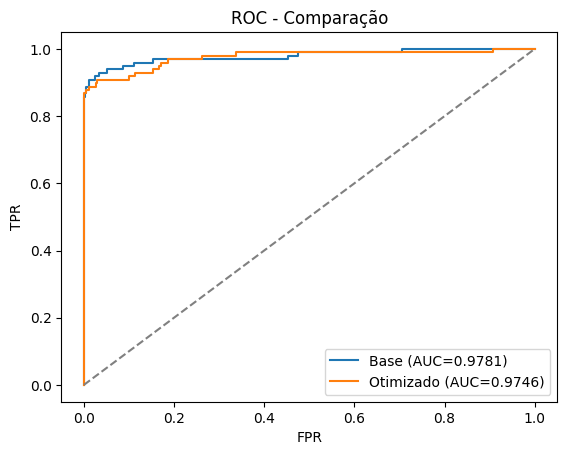

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import pandas as pd

# Obter probabilidades diretamente
y_prob_tuned = tuned.predict(X_test_scaled).ravel()  # retorna probabilidades da classe positiva
y_pred_tuned = (y_prob_tuned >= 0.5).astype(int)     # threshold padrão 0.5

# Métricas
metrics_tuned = {
    "accuracy": accuracy_score(y_test, y_pred_tuned),
    "precision": precision_score(y_test, y_pred_tuned, zero_division=0),
    "recall": recall_score(y_test, y_pred_tuned, zero_division=0),
    "f1": f1_score(y_test, y_pred_tuned, zero_division=0),
    "auc": roc_auc_score(y_test, y_prob_tuned),
}

print(pd.Series(metrics_tuned))

# Matriz de confusão
cm_tuned = confusion_matrix(y_test, y_pred_tuned)
print("\nMatriz de confusão (otimizado):\n", cm_tuned)

# Curvas ROC (comparação com modelo base)
fpr_t, tpr_t, _ = roc_curve(y_test, y_prob_tuned)

plt.figure()
plt.plot(fpr_b, tpr_b, label=f"Base (AUC={metrics_base['auc']:.4f})")
plt.plot(fpr_t, tpr_t, label=f"Otimizado (AUC={metrics_tuned['auc']:.4f})")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC - Comparação")
plt.legend()
plt.show()


**Resultados do Modelo Otimizado**

- **AUC**: 0.9746 (levemente abaixo do baseline de 0.9781 → desempenho muito próximo na separação entre fraudes e não fraudes).  
- **Accuracy**: 99,93% (praticamente igual ao modelo base).  
- **Precision**: 0.84 (leve ganho → menos falsos positivos).  
- **Recall**: 0.73 (pequena queda → algumas fraudes a mais não foram detectadas).  
- **F1**: 0.78 (equilíbrio razoável entre precisão e recall).  

**Matriz de Confusão**

[[56850    14]

 [   26    72]]


- **Falsos positivos**: 14 (classificadas como fraude sem ser).  
- **Falsos negativos**: 26 (fraudes não detectadas).  

---

**Resumo**  
- O ajuste **melhorou a precisão**, mas **reduziu o recall**.  
- O modelo está **estável e robusto**.  
- Possíveis próximos passos:  
  - Ajustar o **threshold** para aumentar a captura de fraudes.  
  - Aplicar **técnicas de balanceamento** (oversampling, undersampling ou geração sintética) para melhorar a sensibilidade.  



## 6) Comparação e salvamento de resultados

Esse trecho organiza as métricas de desempenho dos modelos baseline e otimizado em uma tabela e as salva no arquivo resultados_metricas.csv. Além disso, exporta as matrizes de confusão dos dois modelos para arquivos separados (matriz_confusao_base.csv e matriz_confusao_otim.csv), facilitando a análise e comparação dos resultados.

In [10]:
results = pd.DataFrame([metrics_base, metrics_tuned], index=['Baseline', 'Tuned'])
print(results)

results.to_csv("resultados_metricas.csv", index=True)
pd.DataFrame(cm_base, index=["Neg(Base)","Pos(Base)"], columns=["Pred Neg","Pred Pos"]).to_csv("matriz_confusao_base.csv")
pd.DataFrame(cm_tuned, index=["Neg(Tuned)","Pos(Tuned)"], columns=["Pred Neg","Pred Pos"]).to_csv("matriz_confusao_otim.csv")

print("\nArquivos gerados: resultados_metricas.csv, matriz_confusao_base.csv, matriz_confusao_otim.csv")

          accuracy  precision    recall        f1       auc
Baseline  0.999350   0.801980  0.826531  0.814070  0.978148
Tuned     0.999298   0.837209  0.734694  0.782609  0.974588

Arquivos gerados: resultados_metricas.csv, matriz_confusao_base.csv, matriz_confusao_otim.csv


**Comparação Baseline x Tuned**

- **Baseline**
  - AUC: 0.978 → ligeiramente superior.  
  - Recall: 0.83 → identifica mais fraudes.  

- **Tuned**
  - Precision: 0.84 → menos falsos positivos.  
  - Recall: 0.73 → pequena queda, deixa escapar mais fraudes.  
  - F1 e AUC: levemente abaixo do baseline.  

---

**Resumo**  
- O **modelo otimizado** é mais **conservador**: reduz falsos alarmes (melhor precisão), mas sacrifica um pouco a captura de fraudes (menor recall).  
- O **baseline** é mais **sensível**, capturando mais fraudes, ainda que com mais falsos positivos.  
- Ambos os modelos foram exportados em **arquivos CSV** para análise detalhada.  


## 7) Observações

- Ambos os modelos apresentaram **excelente desempenho**, com **AUC > 0.97**, evidenciando alta capacidade de separação entre transações fraudulentas e legítimas.  
- O **modelo otimizado** melhorou a **precisão** (menos falsos positivos), mas apresentou queda de **recall**, deixando escapar algumas fraudes que o modelo base identificava.  
- As métricas de **acurácia** estão muito altas, mas isso já era esperado devido ao **desbalanceamento extremo da base**.  
- Portanto, as métricas mais relevantes para a análise são **AUC, recall e F1**.  
